# Controversial Game Updates vs. Player Engagement and Sentiment

### How do controversial updates or announcements affect player engagement and sentiment in popular online games?

I think this question has some good direction going for it. It's no surprise that players respond to game updates according to whether they like them or not, and this is no different. What I want to explore deeper is how drastically are playercount and reviews affected, and if there are any long term affects on a game's community.

A lot of data may end up being sourced from scraping instead of official APIs, but I'm willing to work with it for the sake of discovery!


In [50]:
# import some important libraries
import requests
import os
import pandas as pd
import time
import matplotlib.pyplot as plt
import numpy as np
import urllib.parse

from numpy.ma.extras import average

### Exhibit A: Helldivers 2 PSN Controversy

This was kind of a no brainer that this would receive some harsh backlash.

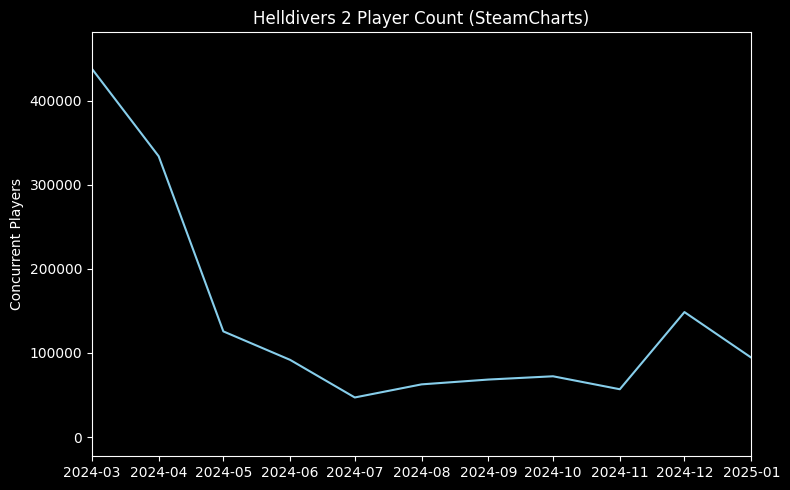

In [51]:
hell_app_id = 553850
# I'm using SteamDB data to show its player count graph. This type of thing is public thankfully!!
helldivers_URL = f"https://steamcharts.com/app/{hell_app_id}/chart-data.json"
# make the DF for the timestamp and players at a given moment
hell_data = requests.get(helldivers_URL).json()
hell_df = pd.DataFrame(hell_data, columns=["timestamp", "players"])
hell_df["datetime"] = pd.to_datetime(hell_df["timestamp"], unit="ms")
hell_df = hell_df.set_index("datetime").drop("timestamp", axis=1)

plt.style.use("dark_background")
fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(hell_df.index, hell_df["players"], color="skyblue", linewidth=1.5)
ax.set_title("Helldivers 2 Player Count (SteamCharts)")
ax.set_ylabel("Concurrent Players")

# Zoom in on a date range — e.g., focus on the last 6–8 months
start = pd.Timestamp("2024-03-01")
end = pd.Timestamp("2025-01-01")
ax.set_xlim(start, end)

# Optionally smooth the data to reduce noise near the end
smooth = hell_df.resample("W").mean()
ax.plot(smooth.index, smooth["players"], color="deepskyblue", linewidth=2)

plt.tight_layout()
plt.show()


Not as big of a plummet in players you would expect from the backlash. Let's try looking at a bigger range and some Steam reviews instead.

In [52]:
print(hell_df.columns)
print(hell_df.head())


Index(['players'], dtype='object')
            players
datetime           
2024-02-01   458208
2024-03-01   437818
2024-04-01   333751
2024-05-01   125574
2024-06-01    91692


In [53]:
# pulled this csv from steamDB, so convenient that this data exists
helldivers_reviews_csv = "Helldivers2SteamCharts.csv"
helldivers_reviews_df = pd.read_csv(helldivers_reviews_csv)
helldivers_reviews_df.fillna(0.0, inplace=True) # fill empty rows with 0s
print(helldivers_reviews_df.head()) # proof


              DateTime  Positive reviews  Negative reviews
0  2024-02-09 00:00:00           11238.0           -4392.0
1  2024-02-10 00:00:00               0.0               0.0
2  2024-02-11 00:00:00            9522.0           -1589.0
3  2024-02-12 00:00:00               0.0               0.0
4  2024-02-13 00:00:00           10918.0           -3941.0


In [54]:

# Convert datetime column to pandas datetime
helldivers_reviews_df['DateTime'] = pd.to_datetime(helldivers_reviews_df['DateTime'])
reviews_df = helldivers_reviews_df.set_index("DateTime")

start_date = pd.Timestamp("2024-03-01")
end_date = pd.Timestamp("2024-08-01")
reviews_filtered = reviews_df.loc[start_date:end_date]

# change it to weekly
reviews_filtered = reviews_filtered.resample('W').sum()
reviews_filtered['Negative reviews'] = reviews_filtered['Negative reviews'].abs() # they're negative by default


# Calculate percentage positive
reviews_filtered['positive_percent'] = (reviews_filtered['Positive reviews'] / (reviews_filtered['Positive reviews'] + reviews_filtered['Negative reviews']) * 100)

reviews_filtered['negative_percent'] = (reviews_filtered['Negative reviews'] / (reviews_filtered['Negative reviews'] + reviews_filtered['Positive reviews']) * 100)

print(reviews_filtered.head())

            Positive reviews  Negative reviews  positive_percent  \
DateTime                                                           
2024-03-03           12017.0               0.0        100.000000   
2024-03-10           47731.0           10368.0         82.154598   
2024-03-17           29247.0            2038.0         93.485696   
2024-03-24           24229.0            2463.0         90.772516   
2024-03-31           23144.0            1490.0         93.951449   

            negative_percent  
DateTime                      
2024-03-03          0.000000  
2024-03-10         17.845402  
2024-03-17          6.514304  
2024-03-24          9.227484  
2024-03-31          6.048551  


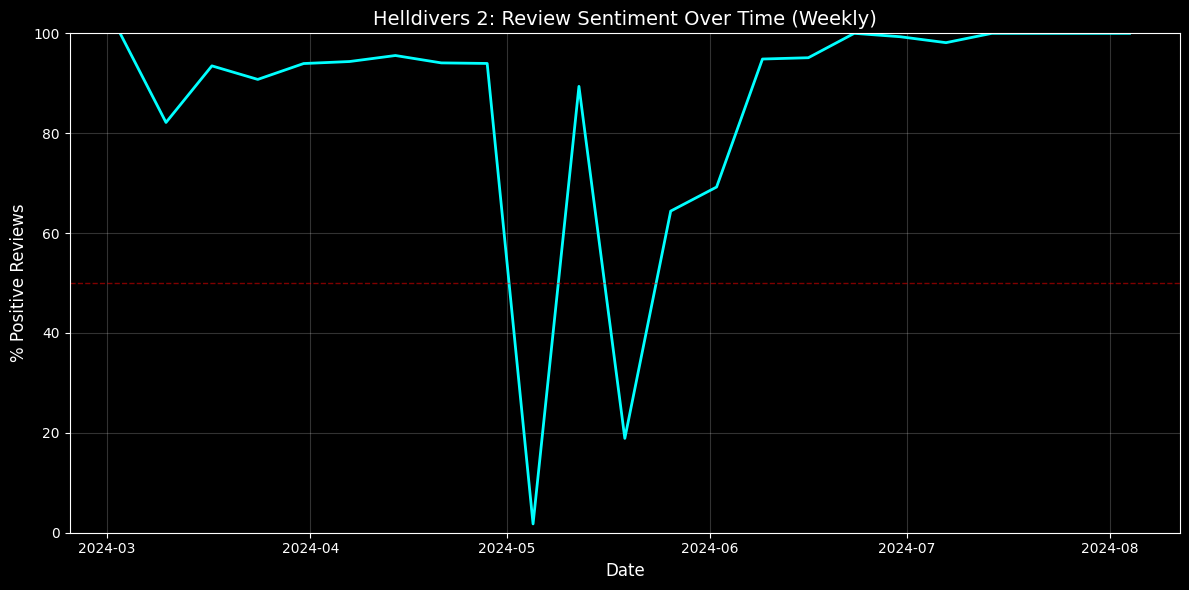

In [55]:
# Plot
plt.style.use("dark_background")
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(reviews_filtered.index, reviews_filtered['positive_percent'], linewidth=2, color='cyan')
ax.axhline(y=50, color='red', linestyle='--', linewidth=1, alpha=0.5)

ax.set_ylabel('% Positive Reviews', fontsize=12)
ax.set_xlabel('Date', fontsize=12)
ax.set_title('Helldivers 2: Review Sentiment Over Time (Weekly)', fontsize=14)
ax.set_ylim(0, 100)
ax.grid(True, alpha=0.2)

plt.tight_layout()
plt.show()

/var/folders/l4/ycnm7gzj4yvg68wlxy_74k0h0000gn/T/ipykernel_1738/3656437920.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  close_filtered['Positive reviews'] = close_filtered['Positive reviews'].replace(0, pos_avg)
/var/folders/l4/ycnm7gzj4yvg68wlxy_74k0h0000gn/T/ipykernel_1738/3656437920.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  close_filtered['Negative reviews'] = close_filtered['Negative reviews'].replace(0, -neg_avg)
/var/folders/l4/ycnm7gzj4yvg68wlxy_74k0h0000gn/T/ipykernel_1738/3656437

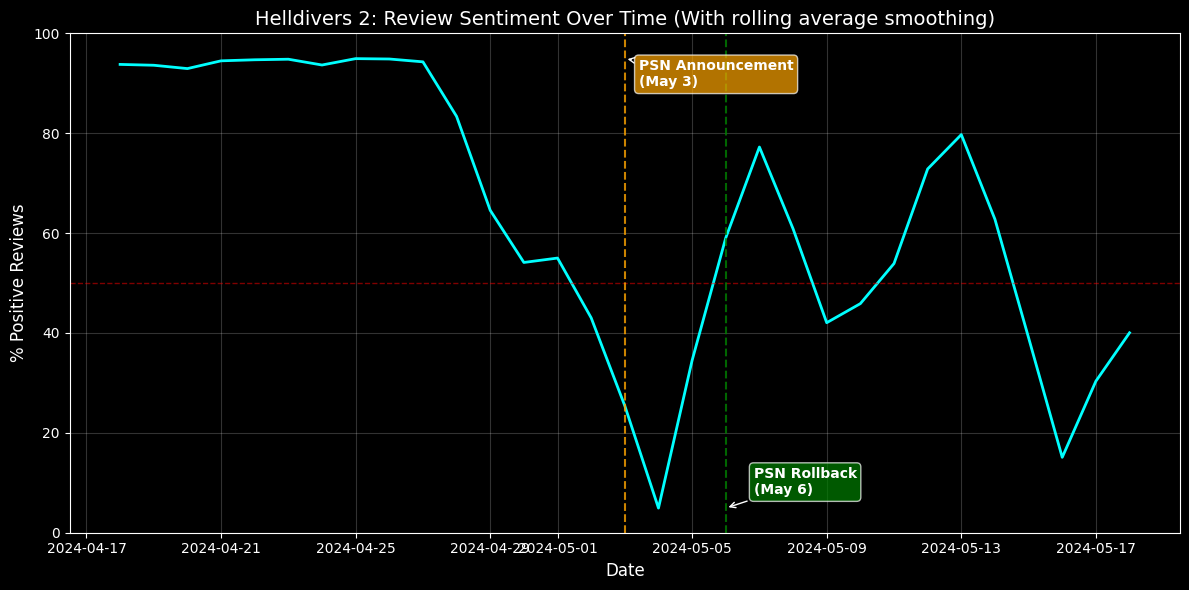

In [68]:
# Plot
plt.style.use("dark_background")
fig, ax = plt.subplots(figsize=(12, 6))
# closer look
close_start = pd.Timestamp("2024-04-18")
close_end = pd.Timestamp("2024-05-18")
close_filtered = reviews_df.loc[close_start:close_end]
pos_avg = close_filtered['Positive reviews'].mean()
neg_avg = close_filtered['Negative reviews'].abs().mean()

# Replace zeros with the averages
close_filtered['Positive reviews'] = close_filtered['Positive reviews'].replace(0, pos_avg)
close_filtered['Negative reviews'] = close_filtered['Negative reviews'].replace(0, -neg_avg)
# Calculate percentage
close_filtered['positive_percent'] = (close_filtered['Positive reviews'] /
                                     (close_filtered['Positive reviews'] +
                                      close_filtered['Negative reviews'].abs()) * 100)
# replace zeros with 50%
#close_filtered['positive_percent'] = close_filtered['positive_percent'].replace(0, 50.0)
# Apply rolling average to smooth the line
close_filtered['positive_percent_smooth'] = close_filtered['positive_percent'].rolling(window=3, center=True, min_periods=1).mean()

# Plot the smoothed version
ax.plot(close_filtered.index, close_filtered['positive_percent_smooth'], linewidth=2, color='cyan')
ax.axhline(y=50, color='red', linestyle='--', linewidth=1, alpha=0.5)

psn_announce = pd.Timestamp("2024-05-03")
psn_rollback = pd.Timestamp("2024-05-06")

ax.axvline(x=psn_announce, color='orange', linestyle='--', alpha=0.8, linewidth=1.5)
ax.axvline(x=psn_rollback, color='green', linestyle='--', alpha=0.8, linewidth=1.5)

ax.annotate('PSN Announcement\n(May 3)',
            xy=(psn_announce, close_filtered['positive_percent_smooth'].max()),
            xytext=(10, -20), textcoords='offset points',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='orange', alpha=0.7),
            arrowprops=dict(arrowstyle='->', color='white'),
            color='white', fontweight='bold')

ax.annotate('PSN Rollback\n(May 6)',
            xy=(psn_rollback, close_filtered['positive_percent_smooth'].min()),
            xytext=(20, 10), textcoords='offset points',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='green', alpha=0.7),
            arrowprops=dict(arrowstyle='->', color='white'),
            color='white', fontweight='bold')

ax.set_ylabel('% Positive Reviews', fontsize=12)
ax.set_xlabel('Date', fontsize=12)
ax.set_title('Helldivers 2: Review Sentiment Over Time (With rolling average smoothing)', fontsize=14)
ax.set_ylim(0, 100)
ax.grid(True, alpha=0.2)

plt.tight_layout()
plt.show()

Looks like the drastic change comes from review sentiment, rather than immediate playercount drop. Players aren't leaving en masse as it may seem from the backlash on social media boards such as Reddit and X. As the company rolled back the decision, it looks as if it were almost instant appreciation by the playerbase. Looks like quick developer response can save a game from going down under from poor business decisions.

### Exhibit B: No Man's Sky - Launch Disaster

Missing features, technical issues, and unintuitive game design were a recipe for disaster for this game on release. This game released in 2016, and since then has received update after update to create one of the biggest redemption arcs in the industry.

In [82]:
noman_app_id = 275850
noman_csv = "NoMansSkyPlayerCount.csv"
noman_df = pd.read_csv(noman_csv)

helldivers_reviews_df.fillna(0.0, inplace=True) # fill empty rows with 0s
helldivers_reviews_df['Negative reviews'] = helldivers_reviews_df['Negative reviews'].abs() # Make the negatives absolute
print(helldivers_reviews_df.head()) # proof

    DateTime  Positive reviews  Negative reviews
0 2024-02-09           11238.0            4392.0
1 2024-02-10               0.0               0.0
2 2024-02-11            9522.0            1589.0
3 2024-02-12               0.0               0.0
4 2024-02-13           10918.0            3941.0


KeyError: 'players'

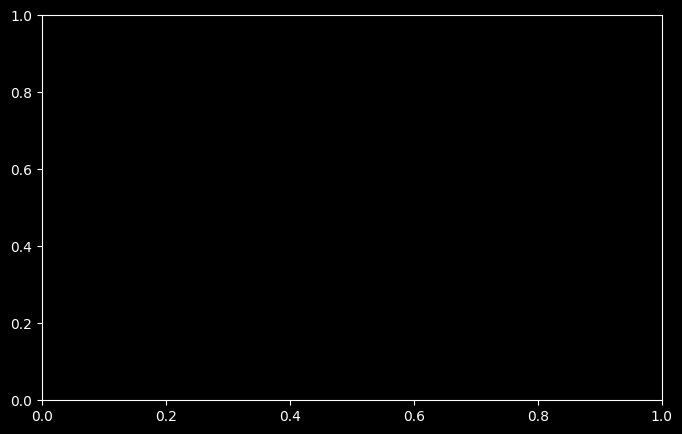

In [83]:
plt.style.use("dark_background")
fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(noman_df.index, noman_df["players"], color="skyblue", linewidth=1.5)
ax.set_title("No Man's Sky Player Count (SteamCharts)")
ax.set_ylabel("Concurrent Players")

# Zoom in on a date range — e.g., focus on the last 6–8 months
start = pd.Timestamp("2016-11-01")
end = pd.Timestamp("2025-01-01")
ax.set_xlim(start, end)

# Optionally smooth the data to reduce noise near the end
smooth = noman_df.resample("W").mean()
ax.plot(smooth.index, smooth["players"], color="deepskyblue", linewidth=2)

plt.tight_layout()
plt.show()

    DateTime  Positive reviews  Negative reviews
0 2024-02-09           11238.0            4392.0
1 2024-02-10               0.0               0.0
2 2024-02-11            9522.0            1589.0
3 2024-02-12               0.0               0.0
4 2024-02-13           10918.0            3941.0


### Exhibit C: Various Runescape updates over the years.

MMOs are a doozy. There's always some update/proposal that gets players *LIVID*. However, I think this will help with my question, since a game like this is subscription based, the impact of these updates might be more dramatic!

In [ ]:
pass